### Notebook to investigate parenteral opioid dispensing trends
A notebook using [English Prescribing Data](https://www.nhsbsa.nhs.uk/prescription-data/prescribing-data/english-prescribing-data-epd) to investigate trends in parenteral opioid dispensing data.
- [Imports](#IMPORTS)
- [Standard functions](#FUNCTIONS)
- [OpenPrescribing data extract](#OPBNF)
- [Item plots](#CHARTS)

<a id='IMPORTS'></a>
### Imports
Import libraries required for analysis

In [1]:
#import libraries required for analysis
from ebmdatalab import bq
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

#set to display all rows in data
#pd.set_option('display.max_rows', None)

<a id='FUNCTIONS'></a>
### Standard functions
Setup standard functions

In [2]:
def plot(df, column_to_plot, chart_title, y_label, y_min='default', y_max='default', lockdownline=False):
    ax = df.groupby(["month"])[column_to_plot].sum().plot(kind='line', title=chart_title)
    plt.xticks(rotation=90);
    plt.ylabel(y_label);
    if (y_min!='default'):
        plt.ylim((y_min, y_max));
    else:
        y_max=df[column_to_plot].max() * 1.05
    if (lockdownline):
        plt.vlines(x=[pd.to_datetime("2020-03-23")], ymin=0, ymax=int(y_max), colors="red", ls="--", label="Start of restrictions");
    plt.grid();

<a id='OPBNF'></a>
### OpenPrescribing data extract
Get [English Prescribing Data](https://www.nhsbsa.nhs.uk/prescription-data/prescribing-data/english-prescribing-data-epd) from BigQuery for monthly items based on BNF codes in this [codelist](https://www.opencodelists.org/codelist/opensafely/opioid-containing-medicines-parenteral-excluding-drugs-for-substance-misuse-dmd/55a533f9/).

In [4]:
#OpenPrescribing BNF codes
sql = '''
SELECT
     CAST(month AS DATE) AS month,
     SUM (CASE WHEN bnf_code IN ("040702020AAAAAA", "040702020AAABAB", "040702020BBAAAA", "040702020BBABAB", "040702040AAABAB",
                                 "040702040BBABAB", "040702040BDAFAB", "040702050AAALAL", "040702050AAAMAM", "040702050AAANAN", 
                                 "040702050AAAPAP", "040702050BBAHAL", "040702050BBAIAM", "040702050BBAJAN", "040702050BBAKAP", 
                                 "0407020ABAAAAAA", "0407020ABAAABAB", "0407020ABAAAIAI", "0407020ABAAAKAK", "0407020ABAAAPAP", 
                                 "0407020ADAAALAL", "0407020ADAAAMAM", "0407020ADAAANAN", "0407020ADBBAFAL", "0407020ADBBAGAM", 
                                 "0407020ADBBAHAN", "0407020ADBJADAL", "0407020ADBJAEAM", "0407020ADBJAFAN", "0407020B0AAAAAA", 
                                 "0407020B0BBABAA", "0407020C0AAAAAA", "0407020C0AAAHAH", "0407020G0AAABAB", "0407020K0AAAAAA", 
                                 "0407020K0AAABAB", "0407020K0AAACAC", "0407020K0AAAEAE", "0407020K0AAAFAF", "0407020K0AAAGAG", 
                                 "0407020K0AAEFEF", "0407020K0AAEGEG", "0407020K0AAEHEH", "0407020K0AAEIEI", "0407020K0AAEMEM", 
                                 "0407020M0AAA3A3", "0407020M0AAA6A6", "0407020M0AAA8A8", "0407020M0AAACAC", "0407020M0AAANAN", 
                                 "0407020M0AAATAT", "0407020M0AAAVAV", "0407020M0AAAWAW", "0407020M0AABHBH", "0407020M0AABKBK", 
                                 "0407020M0BBABAV", "0407020M0BBACA3", "0407020M0BBADAT", "0407020M0BBAEAN", "0407020M0BBAHA6", 
                                 "0407020M0BBAIAC", "0407020M0BCAAAV", "0407020M0BCABAC", "0407020M0BCACA6", "0407020M0BCADAN", 
                                 "0407020P0AAAZAZ", "0407020P0AABABA", "0407020P0AABBBB", "0407020P0AABCBC", "0407020Q0AAA2A2", 
                                 "0407020Q0AAA3A3", "0407020Q0AAA4A4", "0407020Q0AAA5A5", "0407020Q0AAA8A8", "0407020Q0AAAAAA", 
                                 "0407020Q0AAABAB", "0407020Q0AAACAC", "0407020Q0AAADAD", "0407020Q0AAAEAE", "0407020Q0AAAFAF", 
                                 "0407020Q0AAAMAM", "0407020Q0AABCBC", "0407020Q0AADIDI", "0407020Q0AAELEL", "0407020Q0AAENEN", 
                                 "0407020Q0AAFCFC", "0407020Q0AAFJFJ", "0407020Q0AAFKFK", "0407020Q0AAFPFP", "0407020Q0AAFRFR", 
                                 "0407020Q0AAFTFT", "0407020Q0AAFVFV", "0407020Q0AAFWFW", "0407020Q0AAFZFZ", "0407020Q0AAGAGA", 
                                 "0407020Q0BEABFJ", "0407020U0AAAAAA", "0407020U0AAACAC", "0407020U0BBAAAA", "0407020U0BBABAC", 
                                 "0407020V0AAAAAA", "0407020V0AAAEAE", "0407020V0AAAIAI", "0407020V0AAALAL", "0407020V0AAAPAP", 
                                 "0407020V0AAAXAX", "0407020V0AAAZAZ", "0407020V0BCAAAI", "0407020Y0AAAAAA", "0407020Y0AAADAD", 
                                 "0407020Y0BBAAAA", "0407020Y0BBABAD", "1501043A0AAABAB", "1501043A0AAACAC", "1501043A0AAADAD", 
                                 "1501043A0AAAFAF", "1501043A0AAAHAH", "1501043A0BBAAAB", "1501043A0BBABAC", "1501043A0BBADAD"
                                 )  THEN items ELSE 0 END) as ParenteralOpioids,
 FROM hscic.normalised_prescribing
 WHERE month >= '2018-01-01'
 GROUP BY month
 ORDER BY month'''

OP_DF = bq.cached_read(sql, csv_path=os.path.join('../..','data','parenteralopioids.csv'))

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=jgSvqeRL3mrwehwjeq0zMZNL1qfSUS&prompt=consent&access_type=offline


Enter the authorization code:  4/1AfgeXvsBSKgBTSm8nQCBuS4P7tmeRtgrTZGITjt7emDbCHcNZ67ug_MB59E


Downloading: 100%|██████████| 57/57 [00:00<00:00, 262.22rows/s]


In [5]:
OP_DF

,month,ParenteralOpioids
0,2018-01-01,25954
1,2018-02-01,22172
2,2018-03-01,24303
3,2018-04-01,21738
4,2018-05-01,22295
5,2018-06-01,21485
6,2018-07-01,21284
7,2018-08-01,21947
8,2018-09-01,20256
9,2018-10-01,22564


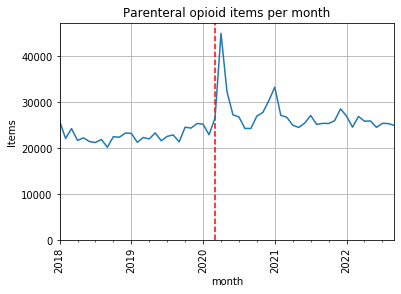

In [6]:
plot(
    df=OP_DF, 
    column_to_plot='ParenteralOpioids', 
    chart_title="Parenteral opioid items per month", 
    y_label='Items', 
    y_min=0, 
    y_max=OP_DF['ParenteralOpioids'].max() * 1.05, 
    lockdownline=True
)